source: https://gist.github.com/ShawnHymel/79237fe6aee5a3653c497d879f746c0c#file-tflite_sinewave_training-ipynb

In [1]:
%tensorflow_version 2.1

UsageError: Line magic function `%tensorflow_version` not found.


In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from keras import layers

In [12]:
# Print versions
!python3 --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + keras.__version__)

Python 3.10.12


Numpy 1.26.0
TensorFlow 2.14.0
Keras 2.14.0


In [13]:
# Settings
nsamples = 1000     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set
tflite_model_name = 'sine_model'  # Will be given .tflite suffix
c_model_name = 'sine_model'       # Will be given .h suffix
     

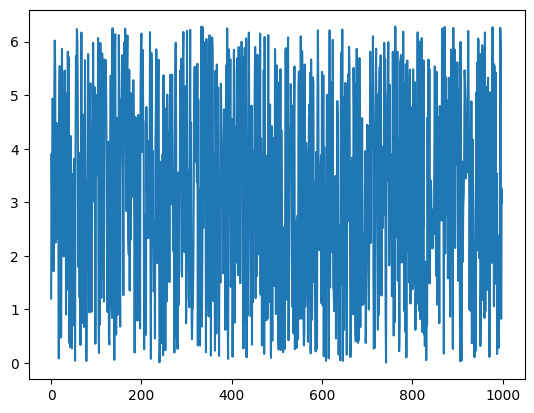

In [14]:
# Generate some random samples
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

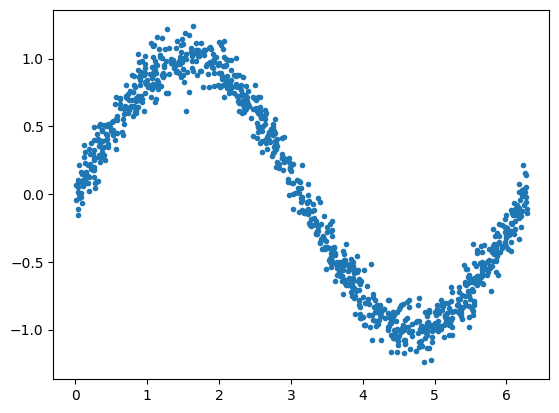

In [15]:
# Create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.1 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

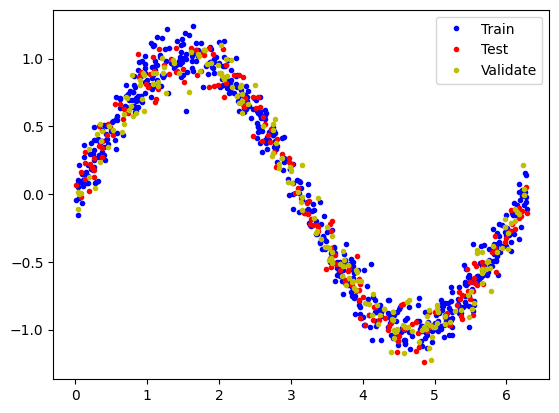

In [16]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [17]:
# Create a model
model = tf.keras.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

2024-03-05 17:04:50.762966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-05 17:04:50.763659: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
# View model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [20]:
# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
6/6 [==============================] - 2s 44ms/step - loss: 0.9209 - mae: 0.9209 - val_loss: 0.8171 - val_mae: 0.8171
Epoch 2/500
6/6 [==============================] - 0s 11ms/step - loss: 0.7373 - mae: 0.7373 - val_loss: 0.6537 - val_mae: 0.6537
Epoch 3/500
6/6 [==============================] - 0s 13ms/step - loss: 0.6205 - mae: 0.6205 - val_loss: 0.5655 - val_mae: 0.5655
Epoch 4/500
6/6 [==============================] - 0s 13ms/step - loss: 0.5677 - mae: 0.5677 - val_loss: 0.5321 - val_mae: 0.5321
Epoch 5/500
6/6 [==============================] - 0s 14ms/step - loss: 0.5436 - mae: 0.5436 - val_loss: 0.5130 - val_mae: 0.5130
Epoch 6/500
6/6 [==============================] - 0s 11ms/step - loss: 0.5272 - mae: 0.5272 - val_loss: 0.4971 - val_mae: 0.4971
Epoch 7/500
6/6 [==============================] - 0s 11ms/step - loss: 0.5071 - mae: 0.5071 - val_loss: 0.4789 - val_mae: 0.4789
Epoch 8/500
6/6 [==============================] - 0s 9ms/step - loss: 0.4928 - mae: 0.492

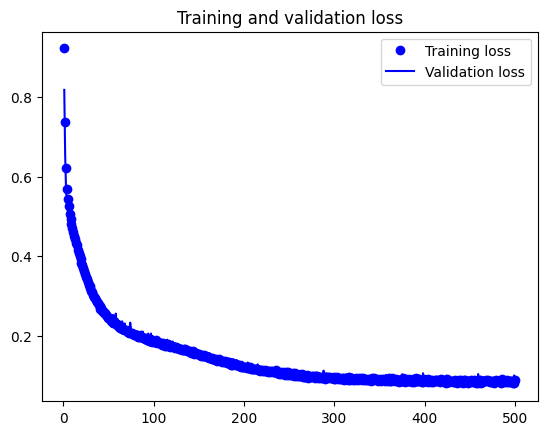

In [21]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

7/7 [==============================] - 0s 2ms/step


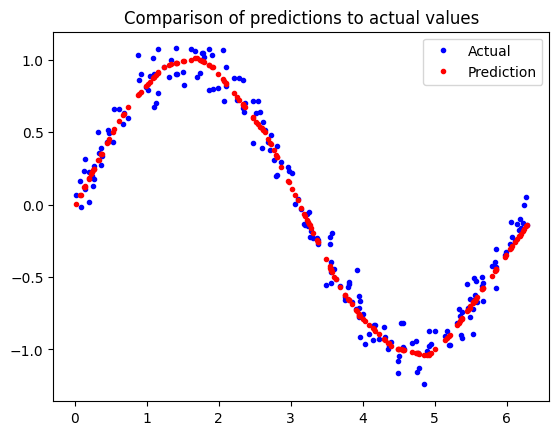

In [22]:
# Plot predictions against actual values
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [26]:
model.save('sine_model.keras')

In [23]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpfvg95c6n/assets


INFO:tensorflow:Assets written to: /tmp/tmpfvg95c6n/assets
2024-03-05 17:05:52.708266: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-03-05 17:05:52.708329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-03-05 17:05:52.712883: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfvg95c6n
2024-03-05 17:05:52.713837: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-03-05 17:05:52.713872: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfvg95c6n
2024-03-05 17:05:52.716748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-03-05 17:05:52.717927: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-03-05 17:05:52.770893: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

3168

In [24]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [25]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))